# Imports

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/and/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
    print(f'Device {i} name:', torch.cuda.get_device_name(i))

CUDA available True
CUDA version 12.1
cuDNN enabled True
cuDNN version 90100
Device 0 name: NVIDIA GeForce RTX 4070 Laptop GPU


# Data prep

In [4]:
path_to_dataset = "../datasets/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(path_to_dataset)
df = df.sample(frac=0.05, random_state=42)  # Використання частини даних для швидкості
df = df[['Content', 'Label']]

In [5]:
df.count()

Content    36306
Label      36306
dtype: int64

In [6]:
def preprocess(text):
    return word_tokenize(text.lower())

In [7]:
def preprocess(text):
    return word_tokenize(text.lower())
    
df['Content'] = df['Content'].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df['Content'] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df['Content'] = train_df['Content'].apply(encode_tweet)
test_df['Content'] = test_df['Content'].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df['Content'], MAX_LEN)
X_test = pad_sequences(test_df['Content'], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df['Label'])
y_test = le.transform(test_df['Label'])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
# Функція для валідації моделі
def validate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tweets, labels in test_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Функція для тестування моделі з виведенням матриці неточностей
def test_model_with_report_and_confusion_matrix(model, test_loader, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"../models/{model_name}_confusion_matrix.png")
    plt.show()

# Візуалізація графіків втрат і точності
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name='model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"../models/{model_name}_metrics.png")
    plt.show()

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        # Додаємо прогрес-бар для тестування
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())  # Використовуємо .tolist() замість numpy
    return all_preds

# Exp 1

In [11]:
# Define LSTM Model
class HateSpeechLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, output_dim=1):
        super(HateSpeechLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

# Model setup
vocab_size = len(word_to_idx) + 1  # Ensure padding token is included
model = HateSpeechLSTM(vocab_size)

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_losses, val_losses = [], []

In [12]:
# Training and Evaluation
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for tweets, labels in train_loader:
        labels = labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for tweets, labels in test_loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

    # Calculate average loss
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Monitoring
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Epoch 1/10 - Loss: 0.6757, Val Loss: 0.6620, Accuracy: 0.6029, Precision: 0.5894, Recall: 0.7222, F1 Score: 0.6491
Epoch 2/10 - Loss: 0.6023, Val Loss: 0.5360, Accuracy: 0.7381, Precision: 0.7050, Recall: 0.8340, F1 Score: 0.7641
Epoch 3/10 - Loss: 0.4714, Val Loss: 0.4755, Accuracy: 0.7769, Precision: 0.7525, Recall: 0.8364, F1 Score: 0.7923
Epoch 4/10 - Loss: 0.3786, Val Loss: 0.4591, Accuracy: 0.7930, Precision: 0.7831, Recall: 0.8202, F1 Score: 0.8012
Epoch 5/10 - Loss: 0.3084, Val Loss: 0.4580, Accuracy: 0.7952, Precision: 0.7713, Recall: 0.8492, F1 Score: 0.8084
Epoch 6/10 - Loss: 0.2453, Val Loss: 0.5068, Accuracy: 0.7974, Precision: 0.7760, Recall: 0.8459, F1 Score: 0.8094
Epoch 7/10 - Loss: 0.1924, Val Loss: 0.5292, Accuracy: 0.7915, Precision: 0.7853, Recall: 0.8121, F1 Score: 0.7985
Epoch 8/10 - Loss: 0.1551, Val Loss: 0.6427, Accuracy: 0.7806, Precision: 0.8107, Recall: 0.7419, F1 Score: 0.7748
Epoch 9/10 - Loss: 0.1649, Val Loss: 0.6028, Accuracy: 0.7888, Precision: 0.7858

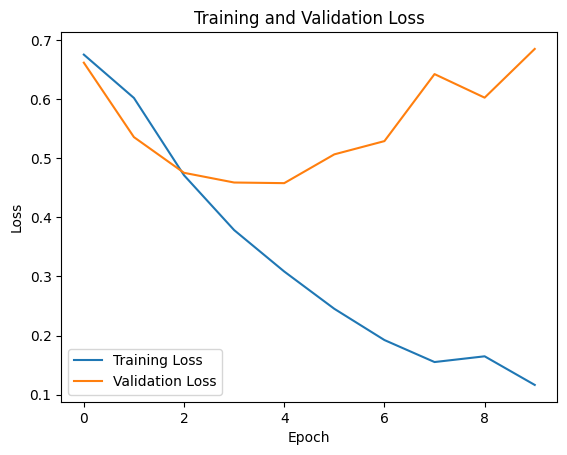

In [13]:
# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Evaluation on the test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for tweets, labels in test_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(tweets)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

In [15]:
# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.7879
Test Precision: 0.7745
Test Recall: 0.8224
Test F1 Score: 0.7977


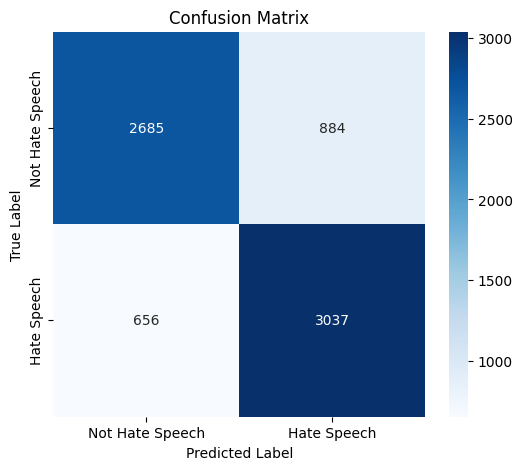

In [16]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Hate Speech', 'Hate Speech'], 
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Exp 2

In [67]:
# Define CNN Model for Hate Speech Detection
class HateSpeechCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, num_filters=100, filter_sizes=[3, 4, 5], output_dim=1, dropout=0.5):
        super(HateSpeechCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers for different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, sent_len, emb_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, sent_len, emb_dim]
        
        # Apply convolution and pooling
        conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        
        # Concatenate pooled outputs
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.sigmoid(self.fc(cat))

# Model setup
vocab_size = len(word_to_idx) + 1
model = HateSpeechCNN(vocab_size)

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_losses, val_losses = [], []


In [68]:
# Training and Evaluation with Progress Bar
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for tweets, labels in train_loader_tqdm:
        labels = labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for tweets, labels in test_loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

    # Calculate average loss and metrics
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Epoch 1/10 - Train Loss: 0.2339, Val Loss: 0.1781, Accuracy: 0.9394, Precision: 0.9417, Recall: 0.9972, F1 Score: 0.9686


Epoch 2/10 - Train Loss: 0.1831, Val Loss: 0.1717, Accuracy: 0.9399, Precision: 0.9456, Recall: 0.9930, F1 Score: 0.9688


Epoch 3/10 - Train Loss: 0.1559, Val Loss: 0.1724, Accuracy: 0.9370, Precision: 0.9499, Recall: 0.9848, F1 Score: 0.9670


Epoch 4/10 - Train Loss: 0.1279, Val Loss: 0.1814, Accuracy: 0.9362, Precision: 0.9526, Recall: 0.9809, F1 Score: 0.9665


Epoch 5/10 - Train Loss: 0.1049, Val Loss: 0.1953, Accuracy: 0.9357, Precision: 0.9483, Recall: 0.9853, F1 Score: 0.9664


Epoch 6/10 - Train Loss: 0.0811, Val Loss: 0.2120, Accuracy: 0.9365, Precision: 0.9524, Recall: 0.9814, F1 Score: 0.9667


Epoch 7/10 - Train Loss: 0.0651, Val Loss: 0.2163, Accuracy: 0.9343, Precision: 0.9525, Recall: 0.9788, F1 Score: 0.9655


Epoch 8/10 - Train Loss: 0.0481, Val Loss: 0.2253, Accuracy: 0.9328, Precision: 0.9556, Recall: 0.9737, F1 Score: 0.9646


Epoch 9/10 - Train Loss: 0.0381, Val Loss: 0.2850, Accuracy: 0.9382, Precision: 0.9493, Recall: 0.9868, F1 Score: 0.9677


Epoch 10/10 - Train Loss: 0.0293, Val Loss: 0.3063, Accuracy: 0.9372, Precision: 0.9515, Recall: 0.9832, F1 Score: 0.9671


In [70]:
# Evaluation on the test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for tweets, labels in test_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(tweets)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.9372
Test Precision: 0.9515
Test Recall: 0.9832
Test F1 Score: 0.9671


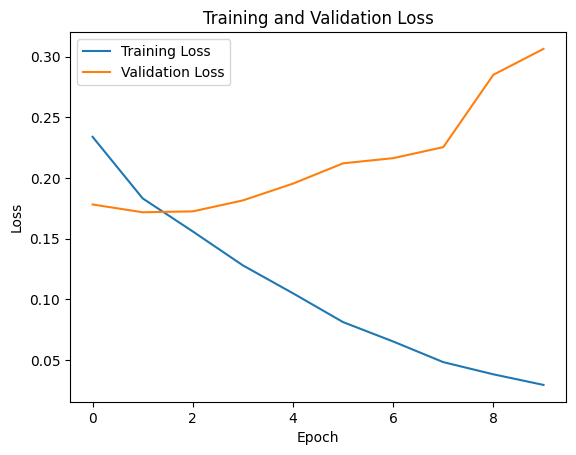

In [71]:
# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

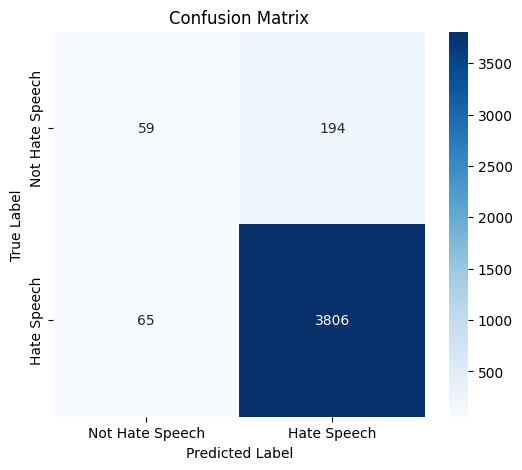

In [72]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Hate Speech', 'Hate Speech'], 
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Exp 3

In [73]:
path_to_dataset = "../datasets/FinalBalancedDataset.csv"
df = pd.read_csv(path_to_dataset)

In [74]:
df.count()

Unnamed: 0    56745
Toxicity      56745
tweet         56745
dtype: int64

In [76]:
df['Toxicity'].unique()

array([0, 1])

In [77]:
df.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [78]:
content_lbl, class_lbl = 'tweet', 'Toxicity'

In [79]:
df = df[[content_lbl, class_lbl]]

In [80]:
df = df[df[class_lbl] != 2]

In [81]:
df.count()

tweet       56745
Toxicity    56745
dtype: int64

In [82]:
df.head()

,tweet,Toxicity
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [83]:
def preprocess(text):
    return word_tokenize(text.lower())
    
df[content_lbl] = df[content_lbl].apply(preprocess)
# Розділення на тренувальну та тестову вибірки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Побудова словника
all_words = [word for tweet in train_df[content_lbl] for word in tweet]
vocab = sorted(set(all_words))
word_to_idx = {word: idx+1 for idx, word in enumerate(vocab)}
vocab_size = len(vocab) + 1  # +1 для padding

# Кодування твітів
def encode_tweet(tweet):
    return [word_to_idx[word] for word in tweet if word in word_to_idx]

train_df[content_lbl] = train_df[content_lbl].apply(encode_tweet)
test_df[content_lbl] = test_df[content_lbl].apply(encode_tweet)

# Додавання padding
def pad_sequences(sequences, max_len):
    return np.array([seq + [0]*(max_len-len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences])

MAX_LEN = 100
X_train = pad_sequences(train_df[content_lbl], MAX_LEN)
X_test = pad_sequences(test_df[content_lbl], MAX_LEN)

# Кодування міток
le = LabelEncoder()
y_train = le.fit_transform(train_df[class_lbl])
y_test = le.transform(test_df[class_lbl])

# Створення датасетів та DataLoader
class HateSpeechDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return torch.tensor(self.tweets[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = HateSpeechDataset(X_train, y_train)
test_dataset = HateSpeechDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [84]:
# Функція для валідації моделі
def validate_model(model, test_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tweets, labels in test_loader:
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Функція для раннього зупинення
def early_stopping(val_losses, patience=3):
    if len(val_losses) < patience + 1:
        return False
    for i in range(1, patience + 1):
        if val_losses[-i] < val_losses[-i - 1]:
            return False
    return True

# Функція для тестування моделі з виведенням матриці неточностей
def test_model_with_report_and_confusion_matrix(model, test_loader, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Non-Hate", "Hate"]))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"../models/{model_name}_confusion_matrix.png")
    plt.show()

# Візуалізація графіків втрат і точності
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name='model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"../models/{model_name}_metrics.png")
    plt.show()

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        # Додаємо прогрес-бар для тестування
        for tweets, labels in tqdm(test_loader, desc='Testing'):
            tweets, labels = tweets.to("cuda"), labels.to("cuda")
            outputs = model(tweets)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().tolist())  # Використовуємо .tolist() замість numpy
    return all_preds

In [85]:
# Define CNN Model for Hate Speech Detection
class HateSpeechCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, num_filters=100, filter_sizes=[3, 4, 5], output_dim=1, dropout=0.5):
        super(HateSpeechCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers for different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, sent_len, emb_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, sent_len, emb_dim]
        
        # Apply convolution and pooling
        conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        
        # Concatenate pooled outputs
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.sigmoid(self.fc(cat))

# Model setup
vocab_size = len(word_to_idx) + 1
model = HateSpeechCNN(vocab_size)

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_losses, val_losses = [], []


In [86]:
# Training and Evaluation with Progress Bar
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for tweets, labels in train_loader_tqdm:
        labels = labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for tweets, labels in test_loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

    # Calculate average loss and metrics
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Epoch 1/10 - Train Loss: 0.2888, Val Loss: 0.1964, Accuracy: 0.9169, Precision: 0.9375, Recall: 0.8643, F1 Score: 0.8994


Epoch 2/10 - Train Loss: 0.1818, Val Loss: 0.1676, Accuracy: 0.9314, Precision: 0.9450, Recall: 0.8921, F1 Score: 0.9178


Epoch 3/10 - Train Loss: 0.1334, Val Loss: 0.1580, Accuracy: 0.9382, Precision: 0.9527, Recall: 0.9010, F1 Score: 0.9261


Epoch 4/10 - Train Loss: 0.0984, Val Loss: 0.1643, Accuracy: 0.9391, Precision: 0.9425, Recall: 0.9141, F1 Score: 0.9281


Epoch 5/10 - Train Loss: 0.0676, Val Loss: 0.1775, Accuracy: 0.9396, Precision: 0.9439, Recall: 0.9137, F1 Score: 0.9285


Epoch 6/10 - Train Loss: 0.0468, Val Loss: 0.1996, Accuracy: 0.9396, Precision: 0.9435, Recall: 0.9141, F1 Score: 0.9286


Epoch 7/10 - Train Loss: 0.0358, Val Loss: 0.2314, Accuracy: 0.9390, Precision: 0.9489, Recall: 0.9069, F1 Score: 0.9274


Epoch 8/10 - Train Loss: 0.0293, Val Loss: 0.2699, Accuracy: 0.9397, Precision: 0.9463, Recall: 0.9114, F1 Score: 0.9286


Epoch 9/10 - Train Loss: 0.0209, Val Loss: 0.3162, Accuracy: 0.9379, Precision: 0.9308, Recall: 0.9241, F1 Score: 0.9275


Epoch 10/10 - Train Loss: 0.0174, Val Loss: 0.3533, Accuracy: 0.9388, Precision: 0.9495, Recall: 0.9059, F1 Score: 0.9272


Test Accuracy: 0.9388
Test Precision: 0.9495
Test Recall: 0.9059
Test F1 Score: 0.9272


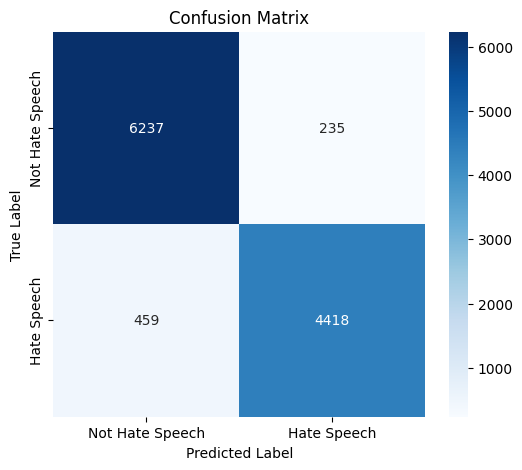

In [87]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for tweets, labels in test_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(tweets)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Hate Speech', 'Hate Speech'], 
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

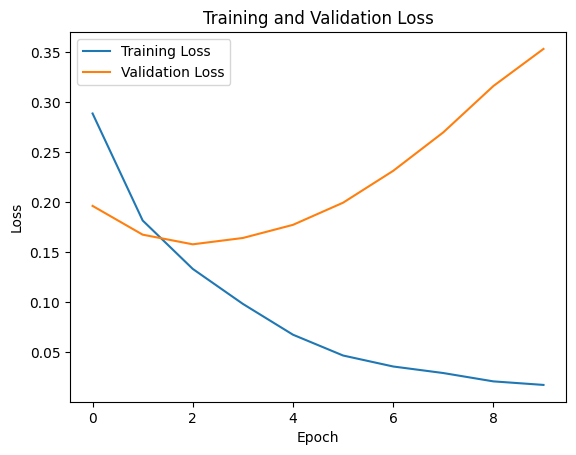

In [88]:
# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()